Please refer to sim_rank_match.ipynb for the explanation of the predation model, here we just swap the add_animal function in the class Ecosystem and the add_agent method in class Animal to use the sort-count-iterate kernel instead of the rank-match kernel.

In [ ]:
import jax.numpy as jnp
import jax.random as random
import jax
import flax

from flax import struct

from abmax.structs import *
from abmax.functions import *
from abmax.contexts.predation.algorithms import *

In [2]:
print("JAX version:", jax.__version__)
print("Flax version:", flax.__version__)

JAX version: 0.4.13
Flax version: 0.7.4


In [3]:
'''small world params'''
KEY = jax.random.PRNGKey(0)
SIM_STEPS = 100 # number of simulation steps
X_POS_MAX = 100 # x dimension of the environment
Y_POS_MAX = 100 # y dimension of the environment
NUM_ECOSYSTEMS = 10 # number of parallel ecosystems to simulate

#Wolf Params
NUM_WOLVES = 1200 # max number of wolves in the ecosystem
NUM_ACTIVE_WOLVES = 400 # initial number of active wolves
REPRO_PROBAB_WOLVES = 0.09 # probability of reproduction for wolves
DELTA_ENERGY_WOLVES = 30.0 # energy gained by wolves when they eat a sheep
WOLF_AGENT_TYPE = 2 # agent type for wolves

#Sheep Params
NUM_SHEEP = 1200 # max number of sheep in the ecosystem
NUM_ACTIVE_SHEEP = 600 # initial number of active sheep
REPRO_PROBAB_SHEEP = 0.01 # probability of reproduction for sheep
DELTA_ENERGY_SHEEP = 5.0 # energy gained by sheep when they eat grass
SHEEP_AGENT_TYPE = 1 # agent type for sheep

#grass Params
REGROWTH_TIME = 20 # time it takes for grass to regrow, grass can be eaten only after it has regrown
NUM_GRASS = X_POS_MAX * Y_POS_MAX # max number of grass patches in the ecosystem
GRASS_AGENT_TYPE = 0 # agent type for grass

In [4]:
'''Large world params'''

''' Uncomment below to run large world sim
KEY = jax.random.PRNGKey(0)
SIM_STEPS = 100
X_POS_MAX = 1000
Y_POS_MAX = 1000
NUM_ECOSYSTEMS = 10

#Wolf Params
NUM_WOLVES = 12000
NUM_ACTIVE_WOLVES = 4000
REPRO_PROBAB_WOLVES = 0.09
DELTA_ENERGY_WOLVES = 30.0
WOLF_AGENT_TYPE = 2

#Sheep Params
NUM_SHEEP = 12000
NUM_ACTIVE_SHEEP = 6000
REPRO_PROBAB_SHEEP = 0.01
DELTA_ENERGY_SHEEP = 5.0
SHEEP_AGENT_TYPE = 1

#grass Params
REGROWTH_TIME = 20
NUM_GRASS = X_POS_MAX * Y_POS_MAX
GRASS_AGENT_TYPE = 0
'''

' Uncomment below to run large world sim\nKEY = jax.random.PRNGKey(0)\nSIM_STEPS = 100\nX_POS_MAX = 1000\nY_POS_MAX = 1000\nNUM_ECOSYSTEMS = 10\n\n#Wolf Params\nNUM_WOLVES = 12000\nNUM_ACTIVE_WOLVES = 4000\nREPRO_PROBAB_WOLVES = 0.09\nDELTA_ENERGY_WOLVES = 30.0\nWOLF_AGENT_TYPE = 2\n\n#Sheep Params\nNUM_SHEEP = 12000\nNUM_ACTIVE_SHEEP = 6000\nREPRO_PROBAB_SHEEP = 0.01\nDELTA_ENERGY_SHEEP = 5.0\nSHEEP_AGENT_TYPE = 1\n\n#grass Params\nREGROWTH_TIME = 20\nNUM_GRASS = X_POS_MAX * Y_POS_MAX\nGRASS_AGENT_TYPE = 0\n'

In [5]:
ECOSYSTEM_PARAMS = Params(content={'grass_params': {'regrowth_time': REGROWTH_TIME, 'x_max': X_POS_MAX, 'y_max': Y_POS_MAX, 
                                                    'agent_type': GRASS_AGENT_TYPE, 'num_grass': NUM_GRASS},
                                    'wolf_params': {'num_wolves': NUM_WOLVES, 'num_active_wolves': NUM_ACTIVE_WOLVES,
                                                    'reproduction_probab': REPRO_PROBAB_WOLVES, 
                                                    'delta_energy': DELTA_ENERGY_WOLVES, 
                                                    'agent_type': WOLF_AGENT_TYPE},
                                    'sheep_params': {'num_sheeps': NUM_SHEEP, 'num_active_sheeps': NUM_ACTIVE_SHEEP,
                                                    'reproduction_probab': REPRO_PROBAB_SHEEP,
                                                    'delta_energy': DELTA_ENERGY_SHEEP,
                                                    'agent_type': SHEEP_AGENT_TYPE}})

In [6]:
@struct.dataclass
class Animal(Agent):

    @staticmethod
    def create_agent(type, params, id, active_state, key) -> Agent:
        '''
        Create an animal agent (wolf or sheep) with given parameters.
        args:
            type: type of the agent (wolf or sheep)
            params: parameters for the agent
            id: unique id for the agent
            active_state: whether the agent is active (1) or inactive (0)
            key: random key for initialization
        returns:
            agent: initialized agent
        '''
        key, subkey = jax.random.split(key) 
        
        X_pos_max = params.content['x_max']
        Y_pos_max = params.content['y_max']

        agent_params_content = {'reproduction_probab': params.content['reproduction_probab'], 
                                'delta_energy': params.content['delta_energy'], 'X_pos_max': X_pos_max, 
                                'Y_pos_max': Y_pos_max}
        
        agent_params = Params(content=agent_params_content)

        def create_active_agent(): # create state for active agent
            key, *create_keys = jax.random.split(subkey, 4)

            X_pos = jax.random.randint(create_keys[0], minval=0, maxval=X_pos_max-1, shape=(1,))
            Y_pos = jax.random.randint(create_keys[1], minval=0, maxval=Y_pos_max-1, shape=(1,))
            
            # Initial energy between 1.0 and 2.0 * delta_energy(energy gained on eating)
            energy = jax.random.uniform(create_keys[2], minval=1.0, maxval=2.0*params.content['delta_energy'], shape=(1,))

            state_content = {'X_pos': X_pos, 'Y_pos': Y_pos, 'energy': energy, 'reproduce': 0}
            state = State(content=state_content)
            return state
        
        def create_inactive_agent(): # create state for inactive agent
            # inactive agents have position -1, energy -1.0 and reproduce 0
            state_content = {'X_pos': jnp.array([-1]), 'Y_pos': jnp.array([-1]), 'energy': jnp.array([-1.0]), 'reproduce': 0}
            state = State(content=state_content)
            return state
        
        # create state based on active_state which is provided as input
        agent_state = jax.lax.cond(active_state, lambda _: create_active_agent(), 
                                   lambda _: create_inactive_agent(), None)
        
        return Animal(id=id, active_state=active_state, age=0.0, agent_type=type,
                      params=agent_params, state=agent_state, policy=None, key=key)
    
    @staticmethod
    def step_agent(agent, input, step_params) -> Agent:
        '''
        Step the agent based on its current state and input.
        args:
            agent: agent to be stepped
            input: input to the agent (e.g., energy gained from eating)
            step_params: parameters for the step function (not used here)
        returns:
            new_agent: stepped agent with updated state
        '''
        def step_active_agent(): # step function for active agent
            energy_in = input.content['energy_in'] # energy gained from eating
            X_pos = agent.state.content['X_pos'] # current x position
            Y_pos = agent.state.content['Y_pos'] # current y position
            energy = agent.state.content['energy'] # current energy

            key, subkey = jax.random.split(agent.key)
            action = jax.random.randint(subkey, minval=0, maxval=4, shape=(1,)) # random action: 0-right, 1-left, 2-up, 3-down

            # Move the animal
            X_pos_new = jax.lax.cond(action[0] == 0, lambda _: X_pos + 1,  # move right
                                    lambda _: X_pos, None)
            X_pos_new = jax.lax.cond(action[0] == 1, lambda _: X_pos - 1,  # move left
                                    lambda _: X_pos_new, None)
            Y_pos_new = jax.lax.cond(action[0] == 2, lambda _: Y_pos + 1,  # move up
                                    lambda _: Y_pos, None)
            Y_pos_new = jax.lax.cond(action[0] == 3, lambda _: Y_pos - 1, # move down
                                    lambda _: Y_pos_new, None)
            
            # check for boundaries
            X_pos_new = jnp.clip(X_pos_new, 0, agent.params.content['X_pos_max']-1)
            Y_pos_new = jnp.clip(Y_pos_new, 0, agent.params.content['Y_pos_max']-1)

            # update energy: -1 for existing, +energy_in for eating
            energy_new = energy - 1.0 + agent.params.content['delta_energy']*energy_in

            key, reproduce_key = jax.random.split(key)
            rand_float = jax.random.uniform(reproduce_key, shape=(1,)) # random float to decide reproduction

            # if the random float is less than reproduction probability, set reproduce to 1
            reproduce = jax.lax.cond(rand_float[0] < agent.params.content['reproduction_probab'], lambda _: 1, 
                                    lambda _: agent.state.content['reproduce'], None)
            
            new_state_content = {'X_pos': X_pos_new, 'Y_pos': Y_pos_new, 'energy': energy_new, 'reproduce': reproduce}
            new_state = State(content = new_state_content)
            return agent.replace(state = new_state, age = agent.age + 1.0, key=key)
        
        def step_inactive_agent(): # step function for inactive agent
            return agent
        
        new_agent = jax.lax.cond(agent.active_state, lambda _: step_active_agent(), lambda _: step_inactive_agent(), None)
        return new_agent
    
    @staticmethod
    def remove_agent(agent, remove_params)->Agent: # remove agent by setting it to inactive state
        '''
        Remove the agent by setting its state to inactive.
        args:
            agent: agent to be removed
            remove_params: parameters for the remove function (not used here)
        returns:
            new_agent: agent with inactive state
        '''
        state_content = {'X_pos': jnp.array([-1]), 'Y_pos': jnp.array([-1]),
                         'energy': jnp.array([-1.0]), 'reproduce': 0}
        state = State(content=state_content)
        return agent.replace(state=state, active_state=0, age=0.0)
    
    @staticmethod
    def add_agent(agents, idx, add_params) -> Agent:
        '''
        Add a new agent by copying the position and halving the energy of an existing agent. Used by the sort-count-iterate kernel for per agent update.
        args:
            agents: list of all agents in the ecosystem
            idx: index of the agent to be added
            add_params: parameters for the add function, contains indices of agents to copy and set
        returns:
            new_agent: newly added agent 
        '''
        copy_indx = add_params.content['copy_indx']
        set_indx = add_params.content['set_indx']

        agent_to_copy = jax.tree_util.tree_map(lambda x: x[copy_indx[idx]], agents)
        agent_to_set = jax.tree_util.tree_map(lambda x: x[set_indx[idx]], agents)

        # copying the position but halving the energy of the agent to copy
        X_pos = agent_to_copy.state.content['X_pos']
        Y_pos = agent_to_copy.state.content['Y_pos']
        energy = agent_to_copy.state.content['energy']/2

        state_content = {'X_pos': X_pos, 'Y_pos': Y_pos, 'energy': energy, 'reproduce': 0}
        state = State(content=state_content)
        age = 0.0
        active_state = True
        return agent_to_set.replace(state=state, age=age, active_state=active_state)
    
    @staticmethod
    def half_energy(agent, set_params) -> Agent: # set the energy of the agent to half its current energy
        '''
        Set the energy of the agent to half its current energy.
        args:
            agent: agent whose energy is to be halved
            set_params: parameters for the set function (not used here)
        returns:
            new_agent: agent with halved energy
        '''
        state_content = {'X_pos': agent.state.content['X_pos'], 
                         'Y_pos': agent.state.content['Y_pos'], 
                         'energy': agent.state.content['energy']/2, 
                         'reproduce': agent.state.content['reproduce']}
        state = State(content=state_content)
        return agent.replace(state=state)

In [7]:
@struct.dataclass
class Grass(Agent):

    @staticmethod
    def create_agent(type, params, id, active_state, key) -> Agent:
        '''
        Create a grass agent with given parameters.
        args:
            type: type of the agent (grass)
            params: parameters for the agent
            id: unique id for the agent
            active_state: whether the agent is active (1) or inactive (0)
            key: random key for initialization
        returns:
            agent: initialized agent
        '''
        regrowth_time = params.content['regrowth_time'] # time it takes for grass to regrow
    
        X_pos_max = params.content['x_max'] # max x position

        params_content = {'regrowth_time': regrowth_time}
        params = Params(content=params_content)



        X_pos = jnp.array([jnp.mod(id, X_pos_max)]) # assuming a square grid, Y_pos can be calculated from id and X_pos
        Y_pos = jnp.array([jnp.floor_divide(id, X_pos_max)]) # Y_pos calculated from id and X_pos

        key, fully_grown_key, count_down_key = jax.random.split(key, 3)
        
        fully_grown = jax.random.choice(fully_grown_key, a=jnp.array([True, False]), shape=(1,)) # randomly initialize grass as fully grown or not
        
        # if fully grown, count_down is 0, else random between 1 and regrowth_time
        count_down = jax.lax.cond(fully_grown[0], 
                                  lambda _: jnp.array([0]), 
                                  lambda _: jax.random.randint(count_down_key, minval=1, maxval=regrowth_time, shape=(1,)), 
                                  None)

        state_content = {'X_pos': X_pos, 'Y_pos': Y_pos, 'fully_grown': fully_grown, 'count_down': count_down}
        state = State(content=state_content)
        age = 0.0
        return Grass(id=id, active_state=active_state, age=age, agent_type=type, 
                     params=params, state=state, policy=None, key=key)
    
    @staticmethod
    def step_agent(agent, input, step_params) -> Agent:
        '''
        Step the agent based on its current state and input.
        args:
            agent: agent to be stepped
            input: input to the agent (eg is the grass eaten or not)
            step_params: parameters for the step function (not used here)
        returns:
            new_agent: stepped agent with updated state
        '''
        energy_out = input.content['energy_out'] # whether the grass is eaten (1) or not (0)
        count_down = agent.state.content['count_down'] # current count down for regrowth
        fully_grown = agent.state.content['fully_grown'] # whether the grass is fully grown (1) or not (0)
        
        # if grass is eaten, set count_down to regrowth_time and fully_grown to False
        new_count_down, new_fully_grown = jax.lax.cond(energy_out[0], lambda _: (jnp.array([agent.params.content['regrowth_time']]), jnp.array([False])), 
                                                       lambda _: (count_down, fully_grown), None)
        
        # if grass is not fully grown, decrement count_down by 1
        new_count_down = jax.lax.cond(new_fully_grown[0], lambda _: new_count_down, lambda _: new_count_down - 1, None)
        
        # if count_down reaches 0, set fully_grown to True
        new_fully_grown = jax.lax.cond(new_count_down[0] <= 0, lambda _: jnp.array([True]), lambda _: new_fully_grown, None)

        new_grass_state_content = {'X_pos': agent.state.content['X_pos'], 
                                   'Y_pos': agent.state.content['Y_pos'], 
                                   'fully_grown': new_fully_grown, 
                                   'count_down': new_count_down}
        
        new_grass_state = State(content=new_grass_state_content)

        new_grass = agent.replace(state=new_grass_state)
        return new_grass

In [8]:
@struct.dataclass
class Ecosystem():
    wolf_set: Set
    sheep_set: Set
    grass_set: Set

    @staticmethod
    def create_ecosystem(params, key):
        '''
        Create an ecosystem with given parameters.
        args:
            params: parameters for the ecosystem
            key: random key for initialization
        returns:
            ecosystem: initialized ecosystem with sets of grass, wolves and sheeps
        '''
        key, grass_key, wolf_key, sheep_key = jax.random.split(key, 4)

        grass_params, wolf_params, sheep_params = params.content['grass_params'], params.content['wolf_params'], params.content['sheep_params']

        num_grass = grass_params['num_grass']
        grass_agent_type = grass_params['agent_type']
        
        regrowth_time_arr = jnp.tile(grass_params['regrowth_time'], num_grass)
        x_max = grass_params['x_max']
        y_max = grass_params['y_max']
        x_max_arr = jnp.tile(grass_params['x_max'], num_grass)
        grass_create_params = Params(content={'regrowth_time': regrowth_time_arr, 'x_max': x_max_arr})

        grass_agents = create_agents(Grass, params=grass_create_params, num_agents=num_grass, 
                                     num_active_agents=num_grass, agent_type=grass_agent_type, key=grass_key)
        grass_set = Set(agents=grass_agents, num_agents=num_grass, state=None, params=None, policy=None, id=0,
                        num_active_agents=num_grass, key=0, set_type=grass_agent_type)
        
        num_wolves = wolf_params['num_wolves']
        num_active_wolves = wolf_params['num_active_wolves']
        wolf_agent_type = wolf_params['agent_type']

        reproduction_probab_arr = jnp.tile(wolf_params['reproduction_probab'], num_wolves)
        x_max_arr_wolves = jnp.tile(x_max, num_wolves)
        y_max_arr_wolves = jnp.tile(y_max, num_wolves)
        delta_energy_arr = jnp.tile(wolf_params['delta_energy'], num_wolves)
        wolf_create_params = Params(content={'reproduction_probab': reproduction_probab_arr, 
                                             'delta_energy': delta_energy_arr, 
                                             'x_max': x_max_arr_wolves, 
                                             'y_max': y_max_arr_wolves})
        
        wolf_agents = create_agents(Animal, params=wolf_create_params, num_agents=num_wolves,
                                     num_active_agents=num_active_wolves, agent_type=wolf_agent_type, key=wolf_key)
        wolf_set = Set(agents=wolf_agents, num_agents=num_wolves, state=None, params=None, policy=None, id=0,
                        num_active_agents=num_active_wolves, key=None, set_type=wolf_agent_type)
        
        num_sheeps = sheep_params['num_sheeps']
        num_active_sheeps = sheep_params['num_active_sheeps']
        sheep_agent_type = sheep_params['agent_type']

        reproduction_probab_arr_sheep = jnp.tile(sheep_params['reproduction_probab'], num_sheeps)
        x_max_arr_sheep = jnp.tile(x_max, num_sheeps)
        y_max_arr_sheep = jnp.tile(y_max, num_sheeps)
        delta_energy_arr_sheep = jnp.tile(sheep_params['delta_energy'], num_sheeps)
        sheep_create_params = Params(content={'reproduction_probab': reproduction_probab_arr_sheep, 
                                              'delta_energy': delta_energy_arr_sheep, 
                                              'x_max': x_max_arr_sheep, 
                                              'y_max': y_max_arr_sheep})
        sheep_agents = create_agents(Animal, params=sheep_create_params, num_agents=num_sheeps,
                                     num_active_agents=num_active_sheeps, agent_type=sheep_agent_type, key=sheep_key)
        sheep_set = Set(agents=sheep_agents, num_agents=num_sheeps, state=None, params=None, policy=None, id=0,
                        num_active_agents=num_active_sheeps, key=None, set_type=sheep_agent_type)

        return Ecosystem(wolf_set=wolf_set, sheep_set=sheep_set, grass_set=grass_set)
    
    @staticmethod
    def select_reproduce_animals(animals:Agent, select_params:Params):
        return animals.state.content['reproduce']
    
    @staticmethod
    def select_empty_slots(animals:Agent, select_params:Params):
        return jnp.logical_not(animals.active_state)
    
    @staticmethod
    def add_animals(animal_set:Set):
        # select the agents that are ready to reproduce
        select_mask = jax.jit(Ecosystem.select_reproduce_animals)(animal_set.agents, None)
        num_animals_reproduce, repproduce_indx = jit_select_agents(select_func = Ecosystem.select_reproduce_animals, select_params = None, set = animal_set)
        
        # select the empty slots in the set
        num_empty_slots, empty_indx = jit_select_agents(select_func = Ecosystem.select_empty_slots, select_params = None, set = animal_set)
        
        #decide the number of new agents to add
        num_new_agents = jnp.minimum(num_animals_reproduce, num_empty_slots)
        #create the params for the new agents
        set_params = Params(content={'copy_indx': repproduce_indx, 'set_indx': empty_indx})
        #add the new agents
        new_animal_set = jit_set_agents_sci(Animal.add_agent, set_params, num_new_agents, animal_set)

        # half the energy of the parents
        mask_params = Params(content={'set_mask':select_mask})
        # we can use num_changes here as it is the number of parents that were selected
        new_animal_set = jit_set_agents_mask(Animal.half_energy, set_params=None, mask_params=mask_params, 
                                             num_agents=num_new_agents, set=new_animal_set)
        return new_animal_set
        

    @staticmethod
    def step(ecosystem, _t):
        '''
        Step the ecosystem by updating the state of all agents (wolves, sheeps, grass) in the ecosystem.
        1. Interact wolves, sheeps and grass to get the energy gained by wolves and sheeps, and the grass and sheeps eaten.
        2. Step the grass agents using the energy_out signal from the interaction.
        3. Step the sheep agents using the energy_in signal from the interaction.
        4. Step the wolf agents using the energy_in signal from the interaction.
        5. Remove dead sheeps and wolves (energy <= 0 or eaten).
        6. Add new sheeps and wolves that reproduced.
        args:
            ecosystem: ecosystem to be stepped
            _t: current time step (not used here)
        returns:
            new_ecosystem: stepped ecosystem with updated sets of agents
        '''
        #jit_interaction is defined in contexts/predation/algorithms.py and captures the interaction logic between wolves, sheeps and grass
        wolves_energy_in, sheeps_energy_in, sheeps_eaten, grasses_eaten = jit_interaction(ecosystem.wolf_set.agents,
                                                                                           ecosystem.sheep_set.agents,
                                                                                           ecosystem.grass_set.agents)
        grass_step_signal = Signal(content={'energy_out': grasses_eaten})
        new_grass_set = jit_step_agents(Grass.step_agent, None, grass_step_signal, ecosystem.grass_set)

        sheep_step_signal = Signal(content={'energy_in': sheeps_energy_in})
        new_sheep_set = jit_step_agents(Animal.step_agent, None, sheep_step_signal, ecosystem.sheep_set)

        wolf_step_signal = Signal(content={'energy_in': wolves_energy_in})
        new_wolf_set = jit_step_agents(Animal.step_agent, None, wolf_step_signal, ecosystem.wolf_set)

        #remove the dead sheeps and wolves
        eaten_sheep_mask = sheeps_eaten.reshape(-1)
        hungry_sheep_mask = jnp.where(new_sheep_set.agents.state.content['energy'] <= 0.0, 1, 0).reshape(-1)
        dead_sheep_mask = jnp.logical_or(eaten_sheep_mask, hungry_sheep_mask)
        remove_params_sheep = Params(content={'set_mask': dead_sheep_mask})
        new_sheep_set = jit_set_agents_mask(Animal.remove_agent, set_params=None, mask_params=remove_params_sheep, num_agents=-1, set=new_sheep_set)

        dead_wolf_mask = jnp.where(new_wolf_set.agents.state.content['energy'] <= 0.0, 1, 0).reshape(-1)
        remove_params_wolf = Params(content={'set_mask': dead_wolf_mask})
        new_wolf_set = jit_set_agents_mask(Animal.remove_agent, set_params=None, mask_params=remove_params_wolf, num_agents=-1, set=new_wolf_set)

        #add new sheeps and wolves
        new_sheep_set = Ecosystem.add_animals(new_sheep_set)
        new_wolf_set = Ecosystem.add_animals(new_wolf_set)

        return Ecosystem(wolf_set=new_wolf_set, sheep_set=new_sheep_set, grass_set=new_grass_set), (new_wolf_set.num_active_agents, new_sheep_set.num_active_agents)

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
palette = "viridis"
sns.set_palette(palette)

In [10]:
def run_scan(ecosystem,ts):
    ecosystem, (num_wolves, num_sheeps) = jax.lax.scan(Ecosystem.step, ecosystem, ts)
    return ecosystem, (num_wolves, num_sheeps)
jit_run_scan = jax.jit(run_scan)
jit_vmap_run_scan = jax.jit(jax.vmap(run_scan, in_axes=(0, None)))

def run_main(params, key):
    ecosystem = Ecosystem.create_ecosystem(params, key)
    ts = jnp.arange(SIM_STEPS)
    ecosystem, (num_wolves, num_sheeps) = jit_run_scan(ecosystem, ts)
    return ecosystem, (num_wolves, num_sheeps)

def run_main_vmap(params, key, num_ecosystems):
    key, *subkeys = jax.random.split(key, num_ecosystems + 1)
    subkeys = jnp.array(subkeys)
    ecosystems = jax.vmap(Ecosystem.create_ecosystem, in_axes=(None, 0))(params, subkeys)
    ts = jnp.arange(SIM_STEPS)
    ecosystems, (num_wolves, num_sheeps) = jit_vmap_run_scan(ecosystems, ts)
    return ecosystems, (num_wolves, num_sheeps)

def main():
    eco, (num_wolves, num_sheeps) = run_main(ECOSYSTEM_PARAMS, KEY)
    plt.plot(num_wolves, label='Wolves')
    plt.plot(num_sheeps, label='Sheep')
    plt.xlabel('Time Steps')
    plt.ylabel('Number of Agents')
    plt.title('Population Dynamics of Wolves and Sheep')
    plt.legend()
    plt.show()



def main_vmap():
    eco, (num_wolves, num_sheeps) = run_main_vmap(ECOSYSTEM_PARAMS, KEY, NUM_ECOSYSTEMS)
    fig, ax = plt.subplots(figsize=(15, 10))
    for i in range(NUM_ECOSYSTEMS):
        ax.plot(num_wolves[i], label=f'wolves ecosystem {i+1}')
    ax.set_xlabel('time steps', fontsize=50)
    ax.set_ylabel('number of wolves', fontsize=50)
    ax.tick_params(axis='both', which='major', labelsize=25)
    #ax.legend(fontsize=25)
    plt.savefig('./figs/wolf_dynamics_sci.svg', bbox_inches='tight')
    plt.show()

    fig, ax = plt.subplots(figsize=(15, 10))
    for i in range(NUM_ECOSYSTEMS):
        ax.plot(num_sheeps[i], label=f'sheep ecosystem {i+1}')
    ax.set_xlabel('time steps', fontsize=50)
    ax.set_ylabel('number of sheep', fontsize=50)
    ax.tick_params(axis='both', which='major', labelsize=25)
    #ax.legend(fontsize=25)
    plt.savefig('./figs/sheep_dynamics_sci.svg', bbox_inches='tight')
    plt.show()

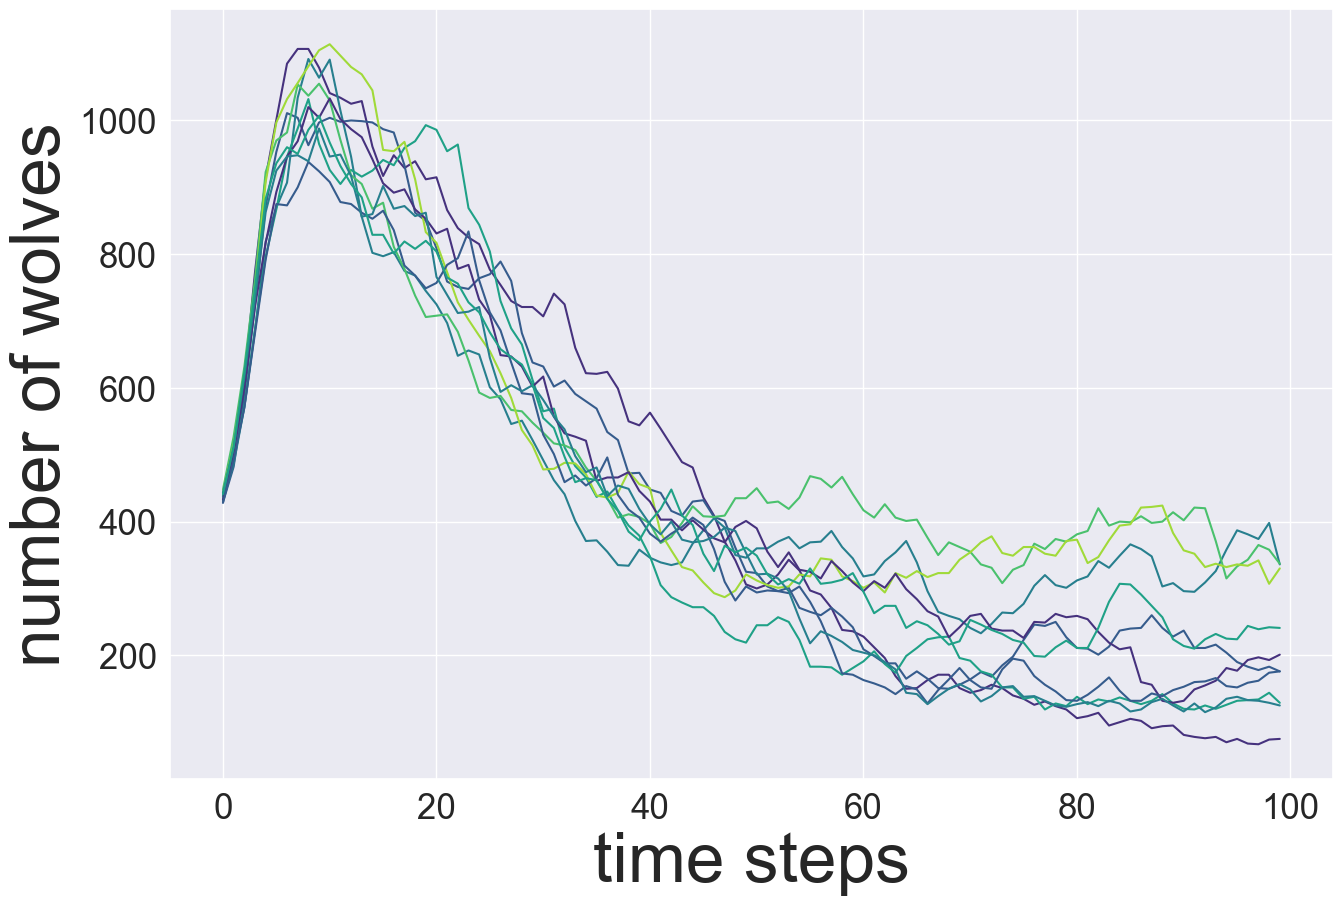

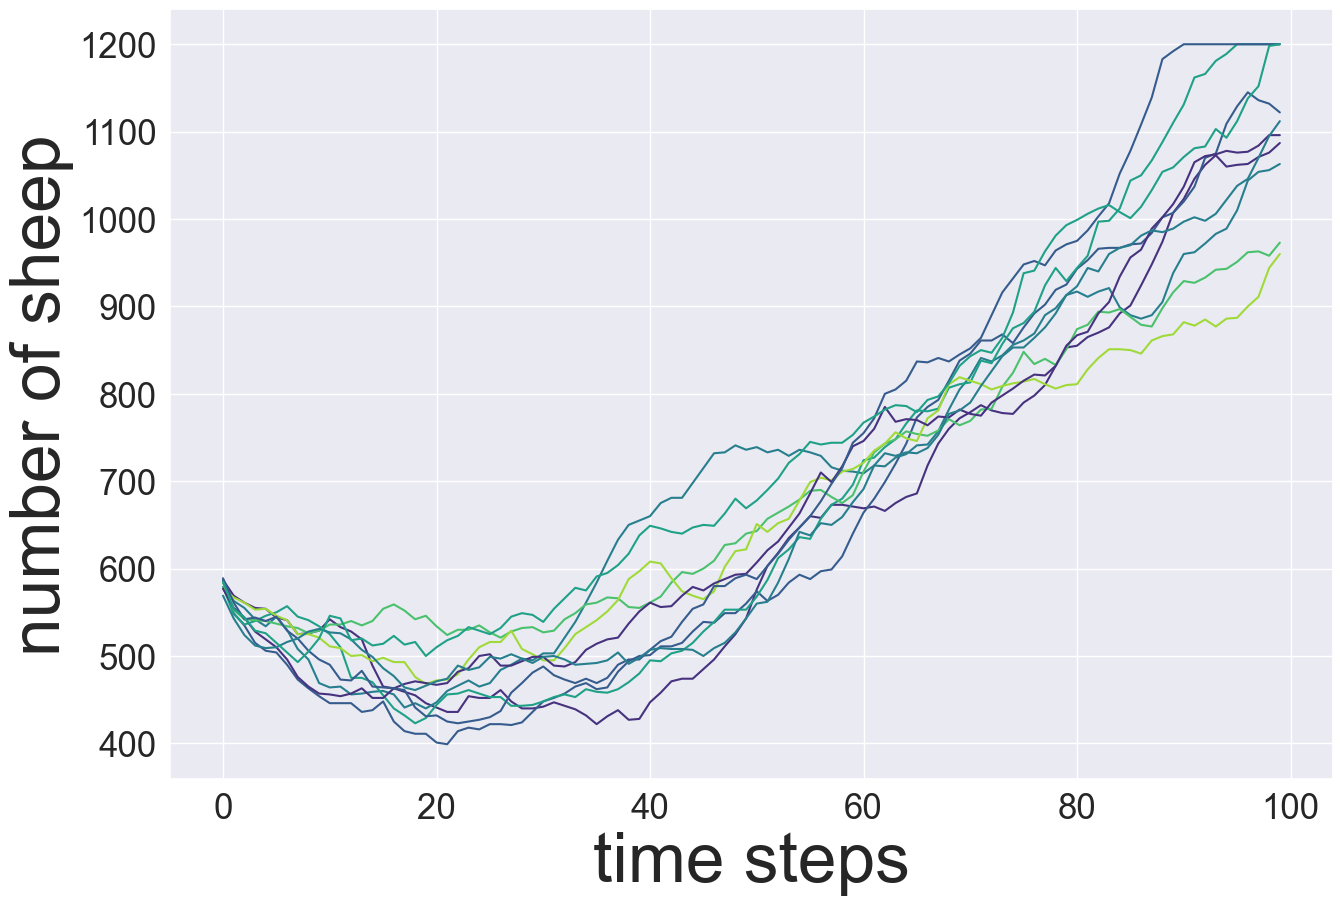

In [11]:
main_vmap()